In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import mean_squared_error, r2_score
os.chdir('C:/Users/louka/Desktop/Machine Learning course/Project/Machine-learning-project')
print(os.getcwd())

C:\Users\louka\Desktop\Machine Learning course\Project\Machine-learning-project


In [2]:
def process_percentage_column(column):
    return column.str.rstrip('%').astype(float) / 100

In [3]:
#We will get the 2012,2016,2020 datasets
df_2012=pd.read_csv('Data/Features_2012.csv')
df_2016=pd.read_csv('Data/Features_2016.csv')
df_2021=pd.read_csv('Data/Features_2021.csv')

df_target_2012=pd.read_csv('Data/2012 Election Results.csv')
df_target_2016=pd.read_csv('Data/2016 Presidential Election Results by State.csv')
df_target_2020=pd.read_csv('Data/2020 elections made.csv')

df_test_2023=pd.read_csv('Data/Features_2023.csv')

df_target_2012.drop([51],axis=0,inplace=True)
df_target_2012[['Percentage Democrat', 'Percentage Republican', 'Percentage Other']] = df_target_2012[['Percentage Democrat', 'Percentage Republican', 'Percentage Other']].apply(pd.to_numeric, errors='coerce')
df_target_2012[['Percentage Democrat', 'Percentage Republican', 'Percentage Other']]=df_target_2012[['Percentage Democrat', 'Percentage Republican', 'Percentage Other']].div(100) #fixed

#print(df_target_2012) #nice
df_target_2020[['Percentage Democrat', 'Percentage Republican', 'Percentage Other']]=df_target_2020[['Percentage Democrat', 'Percentage Republican', 'Percentage Other']].apply(process_percentage_column)

#Merge feature data
df_train=pd.concat([df_2012,df_2016,df_2021],ignore_index=True)
# print(df_train)

# #Merge target data
df_target=pd.concat([df_target_2012,df_target_2016,df_target_2020],ignore_index=True)
#print(df_target)
#Make indices nice etc
df_train.set_index("NAME",inplace=True) #nice
df_target.set_index("STATE",inplace=True)
df_test_2023.set_index("NAME",inplace=True)
#print(df_train)

#Fixes:
#GRAPI is wrong for anything other than 2012. RIP
df_train.drop(df_train.columns[df_train.columns.str.contains('GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME')], axis=1, inplace=True)
df_test_2023.drop(df_test_2023.columns[df_test_2023.columns.str.contains('GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME')], axis=1, inplace=True)

#df_train

In [4]:
#XGBoost Regression
X=df_train
y=df_target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
estimators = [
    ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("scaler", StandardScaler()),
    ('clf', XGBRegressor(random_state=8))
]
pipe=Pipeline(steps=estimators)
pipe.fit(X_train,y_train)
y_pred=pipe.predict(df_test_2023)
print(y_pred)
#test_r2=r2_score(y,y_pred)
# print(test_r2)
df_results=pd.DataFrame(y_pred)
df_results.to_csv(f'Data\Results_2023.csv', index=True)

[[0.3743298  0.58052945 0.03836443]
 [0.39247748 0.5300566  0.04339309]
 [0.51902586 0.4355908  0.03772557]
 [0.39179045 0.5637133  0.03731529]
 [0.6546774  0.29105216 0.03596279]
 [0.5042735  0.39189276 0.03750478]
 [0.5796125  0.39290798 0.04194616]
 [0.5237591  0.37847286 0.03736698]
 [0.78405476 0.06769337 0.03674998]
 [0.5020563  0.43539864 0.0366193 ]
 [0.49549797 0.40663767 0.03742824]
 [0.6461086  0.2972873  0.03717332]
 [0.3578605  0.5077965  0.04148975]
 [0.58859617 0.40390128 0.03652459]
 [0.43445987 0.44463697 0.03596126]
 [0.46184215 0.4401934  0.03422032]
 [0.37209854 0.5278568  0.04016501]
 [0.4440545  0.4781175  0.04313305]
 [0.42888045 0.45057875 0.04308501]
 [0.4342084  0.40975422 0.04332659]
 [0.67913336 0.34698153 0.04227941]
 [0.5888449  0.38760495 0.04630915]
 [0.502799   0.43916595 0.03627715]
 [0.50083256 0.41943723 0.03873556]
 [0.37756544 0.59536517 0.04173687]
 [0.36529326 0.44695652 0.0381314 ]
 [0.38032228 0.545015   0.03685782]
 [0.47002873 0.39716625 0.04

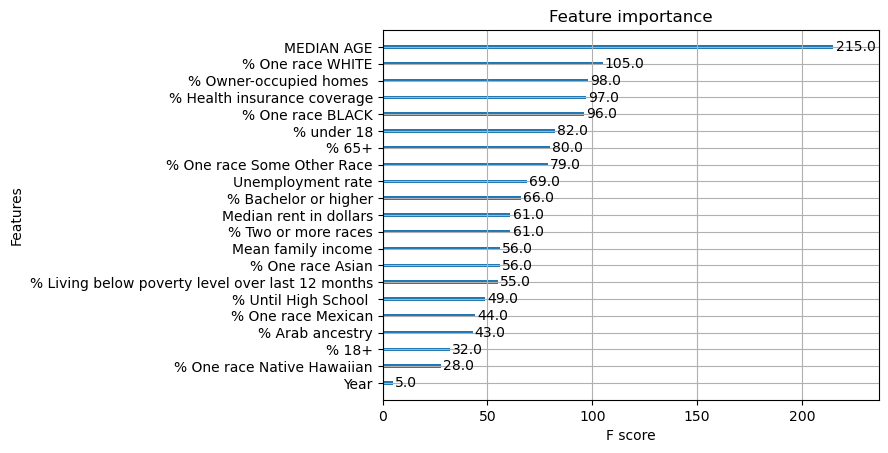

In [5]:
pipe[2].feature_importances_
feature_names = df_train.columns.tolist()
pipe[2].get_booster().feature_names = feature_names
plot_importance(pipe[2])
plt.show()


############################

SECOND TEST

DROP MEDIAN AGE

############################

In [7]:
df_train_2=df_train.drop(columns=['MEDIAN AGE','% under 18'])
df_test_2023_2=df_test_2023.drop(columns=['MEDIAN AGE','% under 18'])
#XGBoost Regression
X=df_train_2
y=df_target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
estimators = [
    ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("scaler", StandardScaler()),
    ('clf', XGBRegressor(random_state=8))
]
pipe=Pipeline(steps=estimators)
pipe.fit(X_train,y_train)
y_pred=pipe.predict(df_test_2023_2)
print(y_pred)
#test_r2=r2_score(y,y_pred)
# print(test_r2)
df_results=pd.DataFrame(y_pred)
df_results.to_csv(f'Data\Results_2023.csv', index=True)

[[0.35561347 0.52536523 0.03747688]
 [0.44149646 0.5072176  0.04470256]
 [0.5194873  0.39653075 0.03764605]
 [0.42129034 0.5614701  0.03696776]
 [0.68545103 0.30002278 0.03599238]
 [0.52138484 0.43474886 0.03747562]
 [0.5669024  0.37708816 0.04445959]
 [0.52820784 0.41101328 0.03900811]
 [0.6993986  0.0546669  0.03723391]
 [0.5222099  0.41971767 0.0363421 ]
 [0.51354945 0.4020183  0.03822803]
 [0.6679715  0.29585055 0.0382077 ]
 [0.33836976 0.5281995  0.04232201]
 [0.57255536 0.4228231  0.03717743]
 [0.49477148 0.45060155 0.03572316]
 [0.4050715  0.47077456 0.03407154]
 [0.41289407 0.55002207 0.04040797]
 [0.42412788 0.5096597  0.04200108]
 [0.43079674 0.47172537 0.04256264]
 [0.45582703 0.41884816 0.04298849]
 [0.6758244  0.30498636 0.04259223]
 [0.58177626 0.38565883 0.04678516]
 [0.4855834  0.5232743  0.03598187]
 [0.49610618 0.4333602  0.03858641]
 [0.37238562 0.5738233  0.04190226]
 [0.4098472  0.4666298  0.03727056]
 [0.40186438 0.53256875 0.03699995]
 [0.4964287  0.43041855 0.04

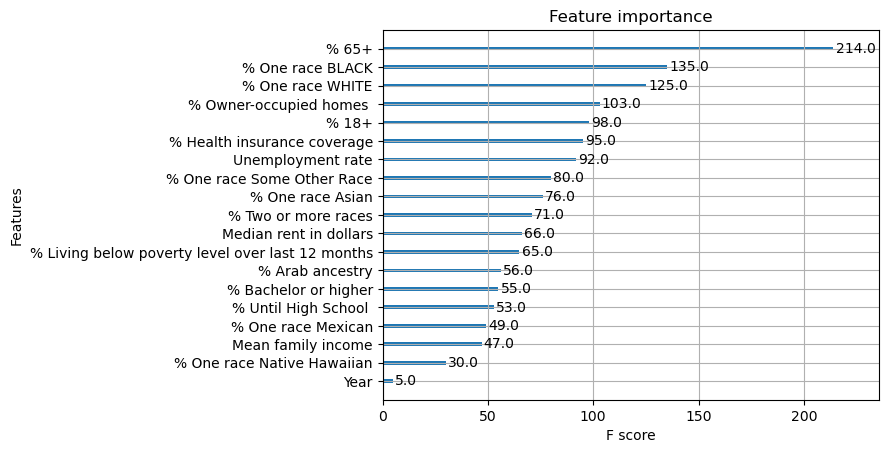

In [8]:
pipe[2].feature_importances_
feature_names = df_train_2.columns.tolist()
pipe[2].get_booster().feature_names = feature_names
plot_importance(pipe[2])
plt.show()


####################

3RD TEST

SHUFFLE  COLUMNS

####################


In [10]:
def swap_columns(df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index(col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [11]:
df_train_3= swap_columns(df_train,'MEDIAN AGE','% Bachelor or higher')
#df_train_3=df_train_3.drop(columns='MEDIAN AGE')
df_test_2023_3= swap_columns(df_test_2023,'MEDIAN AGE','% Bachelor or higher')
# df_test_2023_3=df_test_2023_3.drop(columns='MEDIAN AGE')

# df_train_3= swap_columns(df_train,'MEDIAN AGE','% Bachelor or higher')
# df_test_2023_3= swap_columns(df_test_2023,'MEDIAN AGE','% Bachelor or higher')


#XGBoost Regression
X=df_train_3
y=df_target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
estimators = [
    ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("scaler", StandardScaler()),
    ('clf', XGBRegressor(random_state=8))
]
pipe=Pipeline(steps=estimators)
pipe.fit(X_train,y_train)
y_pred=pipe.predict(df_test_2023_3)
print(y_pred)
#test_r2=r2_score(y,y_pred)
# print(test_r2)
df_results=pd.DataFrame(y_pred)
df_results.to_csv(f'Data\Results_2023_swapped.csv', index=True)

[[0.3743298  0.5812355  0.03836443]
 [0.39247748 0.5300566  0.0440508 ]
 [0.51902586 0.5104412  0.03772557]
 [0.39179045 0.56441927 0.03731529]
 [0.6448515  0.09840113 0.03596279]
 [0.5042735  0.38946494 0.03690351]
 [0.5799153  0.39195287 0.04194616]
 [0.5227391  0.36740544 0.03736698]
 [0.8924606  0.0557867  0.03782749]
 [0.5020563  0.5097904  0.0366193 ]
 [0.49585253 0.48102954 0.03742824]
 [0.6459571  0.09587727 0.03717332]
 [0.36507678 0.5077965  0.04148975]
 [0.58757615 0.40249562 0.03652459]
 [0.43445987 0.440698   0.03596126]
 [0.46184215 0.44745886 0.03422032]
 [0.37209854 0.52739835 0.04016501]
 [0.4440545  0.48020652 0.04313305]
 [0.4196912  0.453688   0.04308501]
 [0.43760663 0.4157822  0.04332659]
 [0.67913336 0.33896625 0.04274813]
 [0.5888449  0.38665783 0.04630915]
 [0.502799   0.43961507 0.03627715]
 [0.50215536 0.4180316  0.03873556]
 [0.3778024  0.59607124 0.04173687]
 [0.36529326 0.4549277  0.0381314 ]
 [0.38753858 0.54553795 0.03685782]
 [0.4704407  0.39670774 0.04

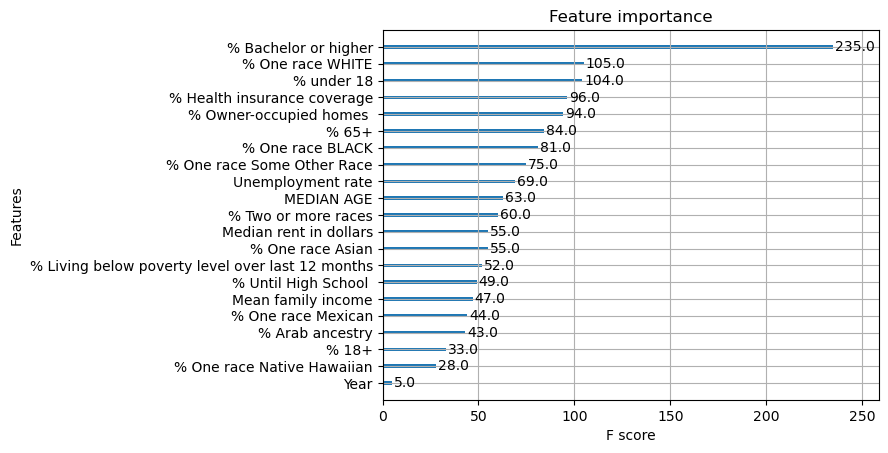

In [12]:
pipe[2].feature_importances_
feature_names = df_train_3.columns.tolist()
pipe[2].get_booster().feature_names = feature_names
plot_importance(pipe[2])
plt.show()


########

BAYES SEARCH CV WAY (EXPERIMENTAL DANGER TOO MUCH SWAG)

########

In [14]:
#We will get the 2012,2016,2020 datasets
df_2012=pd.read_csv('Data/Features_2012.csv')
df_2016=pd.read_csv('Data/Features_2016.csv')
df_2021=pd.read_csv('Data/Features_2021.csv')

df_target_2012=pd.read_csv('Data/2012 Election Results.csv')
df_target_2016=pd.read_csv('Data/2016 Presidential Election Results by State.csv')
df_target_2020=pd.read_csv('Data/2020 elections made.csv')

df_test_2023=pd.read_csv('Data/Features_2023.csv')

df_target_2012.drop([51],axis=0,inplace=True)
df_target_2012[['Percentage Democrat', 'Percentage Republican', 'Percentage Other']] = df_target_2012[['Percentage Democrat', 'Percentage Republican', 'Percentage Other']].apply(pd.to_numeric, errors='coerce')
df_target_2012[['Percentage Democrat', 'Percentage Republican', 'Percentage Other']]=df_target_2012[['Percentage Democrat', 'Percentage Republican', 'Percentage Other']].div(100) #fixed
df_target_2012['Percentage Other'] = df_target_2012['Percentage Other'] + 1e-8
#print(df_target_2012) #nice
df_target_2020[['Percentage Democrat', 'Percentage Republican', 'Percentage Other']]=df_target_2020[['Percentage Democrat', 'Percentage Republican', 'Percentage Other']].apply(process_percentage_column)

#Merge feature data
df_train=pd.concat([df_2012,df_2016,df_2021],ignore_index=True)
# print(df_train)

# #Merge target data
df_target=pd.concat([df_target_2012,df_target_2016,df_target_2020],ignore_index=True)
print(df_target)
#Make indices nice etc
df_train.set_index("NAME",inplace=True) #nice
df_target.set_index("STATE",inplace=True)
df_test_2023.set_index("NAME",inplace=True)
#print(df_train)

#Fixes:
#GRAPI is wrong for anything other than 2012. RIP
df_train.drop(df_train.columns[df_train.columns.str.contains('GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME')], axis=1, inplace=True)
df_test_2023.drop(df_test_2023.columns[df_test_2023.columns.str.contains('GROSS RENT AS A PERCENTAGE OF HOUSEHOLD INCOME')], axis=1, inplace=True)

#df_train

             STATE  Percentage Democrat  Percentage Republican  \
0          Alabama               0.3840                 0.6050   
1           Alaska               0.4080                 0.5480   
2          Arizona               0.4460                 0.5370   
3         Arkansas               0.3690                 0.6060   
4       California               0.6020                 0.3710   
..             ...                  ...                    ...   
148       Virginia               0.5411                 0.4400   
149     Washington               0.5797                 0.3877   
150  West Virginia               0.2970                 0.6863   
151      Wisconsin               0.4945                 0.4882   
152        Wyoming               0.2655                 0.6994   

     Percentage Other  
0        1.000000e-08  
1        1.000000e-08  
2        1.000000e-08  
3        1.000000e-08  
4        1.000000e-08  
..                ...  
148      1.890000e-02  
149      3.2600

In [15]:
df_target_Bayes=df_target.apply(np.log) #Make everything negative
df_target_Bayes

X=df_train
y=df_target_Bayes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
estimators = [
    ("imputation_mean", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("scaler", StandardScaler()),
    ('clf', XGBRegressor(random_state=8))
]
pipe=Pipeline(steps=estimators)

In [16]:
search_space = {
    'clf__max_depth': Integer(2,4),
    'clf__learning_rate': Real(0.1, 1.0, prior='log-uniform'),
    'clf__colsample_bylevel': Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
}
                                       #cv: number of folds
opt = BayesSearchCV(pipe, search_space, cv=10, n_iter=5, scoring='r2', random_state=8) 
# in reality, you may consider setting cv and n_iter to higher values

In [17]:
opt.fit(X_train, y_train)
best_model = opt.best_estimator_
y_pred = best_model.predict(X_test)
print(np.exp(y_pred))
test_r2 = r2_score(y_test, y_pred)
# Output results
print("Best hyperparameters:", opt.best_params_)
print("R^2 score on the test set:", test_r2)

[[5.6416190e-01 4.1189891e-01 1.1716809e-08]
 [5.8445764e-01 3.3215678e-01 3.0632101e-02]
 [5.0388157e-01 4.1206285e-01 2.1676818e-02]
 [5.5463880e-01 4.2701179e-01 9.8028394e-09]
 [5.9295046e-01 4.3539381e-01 2.1618268e-02]
 [3.4925830e-01 5.5928445e-01 2.5617789e-02]
 [3.9761910e-01 5.7730967e-01 3.3550791e-02]
 [4.7735453e-01 4.5372635e-01 4.7684450e-02]
 [4.5085421e-01 4.3300074e-01 2.0330327e-02]
 [5.9712034e-01 3.9545262e-01 2.2801660e-02]
 [5.9161526e-01 4.2368251e-01 1.1440435e-08]
 [6.7383730e-01 3.8108620e-01 1.3701534e-02]
 [4.7401002e-01 4.5006371e-01 3.3164617e-02]
 [3.9723158e-01 5.8027893e-01 2.7784545e-02]
 [4.8706308e-01 4.5290363e-01 1.0578029e-08]
 [4.4325092e-01 5.2570957e-01 2.6853964e-02]
 [3.5564604e-01 5.3406036e-01 5.0631616e-02]
 [5.7884943e-01 4.3874770e-01 1.5887586e-02]
 [5.3091520e-01 4.2499882e-01 3.5652824e-02]
 [4.5548409e-01 3.9832962e-01 4.0514592e-02]
 [3.4506807e-01 6.0546172e-01 1.0686319e-08]
 [3.8904300e-01 6.0100549e-01 9.8936983e-09]
 [4.098197

In [18]:
#Test Model for 2023 data
#df_test_2023.apply(np.log)
y_res=best_model.predict(df_test_2023) #produces a log
y_res=np.exp(y_res) #Get it into normal
print(y_res.shape)
#Normalization
y_res = y_res / y_res.sum(axis=1, keepdims=True)
df_results_2023_Bayes=pd.DataFrame(y_res)
print(df_results_2023_Bayes)
df_results_2023_Bayes.to_csv(f'Data\Results_2023_Bayes.csv', index=True)


(51, 3)
           0         1         2
0   0.395495  0.580725  0.023780
1   0.383543  0.554929  0.061528
2   0.494625  0.474750  0.030624
3   0.378152  0.590530  0.031318
4   0.659766  0.308133  0.032100
5   0.522644  0.429106  0.048250
6   0.555992  0.416839  0.027170
7   0.534015  0.435708  0.030277
8   0.712296  0.257691  0.030013
9   0.473174  0.506680  0.020146
10  0.509747  0.464730  0.025523
11  0.585646  0.380136  0.034218
12  0.371338  0.574407  0.054255
13  0.532083  0.437250  0.030667
14  0.462558  0.505833  0.031609
15  0.451562  0.511760  0.036678
16  0.442728  0.523387  0.033885
17  0.429093  0.539024  0.031884
18  0.405680  0.569799  0.024522
19  0.496540  0.455321  0.048139
20  0.557660  0.411740  0.030600
21  0.552633  0.414304  0.033063
22  0.474056  0.498215  0.027730
23  0.509184  0.456997  0.033819
24  0.354012  0.622485  0.023503
25  0.425727  0.546875  0.027398
26  0.396411  0.568191  0.035397
27  0.473849  0.478742  0.047409
28  0.496127  0.476194  0.027679
29

['MEDIAN AGE', '% under 18', '% 65+', '% 18+', '% One race WHITE', '% One race BLACK', '% Two or more races', '% One race Mexican', '% One race Asian', '% One race Native Hawaiian', '% One race Some Other Race', 'Median rent in dollars', 'Unemployment rate', '% Owner-occupied homes ', '% Living below poverty level over last 12 months', '% Health insurance coverage', 'Mean family income', '% Bachelor or higher', '% Until High School ', '% Arab ancestry', 'Year']
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.9425384185492701,
             colsample_bynode=0.9095956806239844, colsample_bytree=None,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2583790866614921, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
  

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

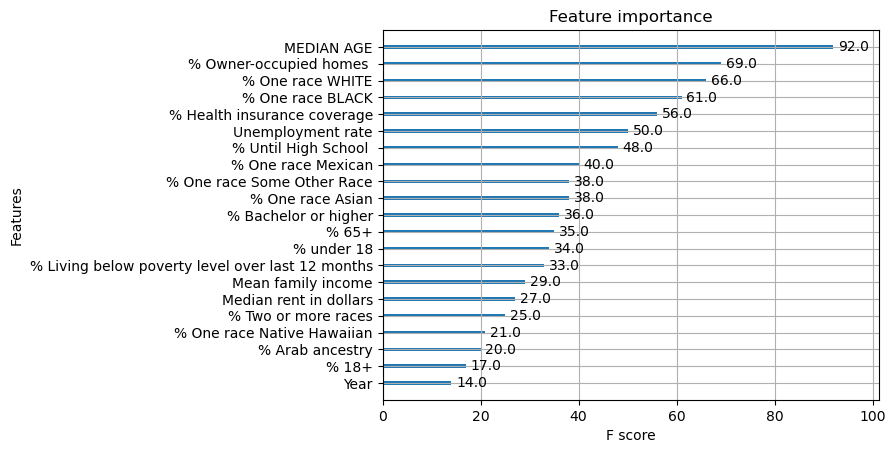

In [19]:
xgboost_step = opt.best_estimator_.steps[2]
xgboost_model = xgboost_step[1]
#Print feature names correctly
feature_names = df_train.columns.tolist()
print(feature_names)
xgboost_model.get_booster().feature_names = feature_names
print (xgboost_model)
plot_importance(xgboost_model)

In [34]:
#Load 2023 election results
df_real_results=pd.read_csv('Data/2023 real Results.csv')
df_real_results.set_index('State',inplace=True)

df_real_results[['Harris (D)', 'Trump (R)', 'Stein (G)']] = df_real_results[['Harris (D)', 'Trump (R)', 'Stein (G)']].apply(process_percentage_column)
df_real_results

,Harris (D),Trump (R),Stein (G)
State,,,
Alabama,0.341,0.646,0.002
Alaska,0.414,0.545,0.007
Arizona,0.467,0.522,0.005
Arkansas,0.336,0.642,0.004
California,0.655,0.329,0.008
Colorado,0.570,0.401,0.012
Connecticut,0.592,0.385,0.008
Delaware,0.580,0.400,0.007
District of Columbia,0.920,0.070,0.005


In [21]:
#R2 score
real_r2 = r2_score(y_res, df_real_results)
print(real_r2)

-2.815068483352661


In [22]:
df_real_results[['Harris (D)', 'Trump (R)', 'Stein (G)']] = df_real_results[['Harris (D)', 'Trump (R)', 'Stein (G)']].apply(pd.to_numeric, errors='coerce')